In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
import cv2
import os

# Czytanie danych

In [2]:
labels = ['Sick', 'Healthy']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                #resized_arr = cv2.resize(img_arr, (250,540))
                data.append([img_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

train = get_training_data('../input/breast-cancer-patients-mris/Breast Cancer Patients MRI\'s/train')
test = get_training_data('../input/breast-cancer-patients-mris/Breast Cancer Patients MRI\'s/validation')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


In [3]:
x_train = []
y_train = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

# Przygotowywanie danych

In [4]:
x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255

x_train = x_train.reshape(-1, 250,540, 1)
y_train = np.array(y_train)

x_test = x_test.reshape(-1, 250,540, 1)
y_test = np.array(y_test)

def to_rgb(x):
    x_rgb = np.zeros((x.shape[0], 250,540, 3))
    for i in range(3):
        x_rgb[..., i] = x[..., 0]
    return x_rgb

x_train = to_rgb(x_train)
x_test = to_rgb(x_test)

# Tworzenie sieci

In [5]:
model = keras.Sequential(
    [
     keras.Input(shape=(250,540,3)),
     layers.Conv2D(32, 3, activation='relu'),
     layers.MaxPooling2D(),
     layers.Conv2D(64, 3, activation='relu'),
     layers.MaxPooling2D(),
     layers.Conv2D(64, 3, activation='relu'),
     layers.Flatten(),
     layers.Dense(10)
    ]
)

2022-09-25 17:34:18.489806: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [6]:
model.compile(
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer=keras.optimizers.Adam(),
  metrics=['accuracy']
)

# Tranowanie

In [7]:
model.fit(
        x_train, 
        y_train, 
        epochs=12, 
        batch_size=64, 
        validation_data = (x_test, y_test))

2022-09-25 17:34:22.263840: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/8
22/22 [==============================] - 124s 6s/step - loss: 1.0511 - accuracy: 0.6293 - val_loss: 0.6509 - val_accuracy: 0.6250
Epoch 2/8
22/22 [==============================] - 121s 6s/step - loss: 0.2494 - accuracy: 0.8986 - val_loss: 0.9358 - val_accuracy: 0.5250
Epoch 3/8
22/22 [==============================] - 122s 6s/step - loss: 0.0926 - accuracy: 0.9707 - val_loss: 1.9629 - val_accuracy: 0.5000
Epoch 4/8
22/22 [==============================] - 120s 5s/step - loss: 0.0266 - accuracy: 0.9921 - val_loss: 2.7170 - val_accuracy: 0.5000
Epoch 5/8
22/22 [==============================] - 121s 6s/step - loss: 0.0104 - accuracy: 0.9971 - val_loss: 2.6658 - val_accuracy: 0.5000
Epoch 6/8
22/22 [==============================] - 123s 6s/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 3.6037 - val_accuracy: 0.4500
Epoch 7/8
22/22 [==============================] - 125s 6s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 3.5466 - val_accuracy: 0.5000
Epoch 8/8
22/22 [===

In [8]:
print("Dokładność: " , model.evaluate(x_test,y_test)[1]*100 , "%")

3/3 [==============================] - 1s 406ms/step - loss: 4.1629 - accuracy: 0.4500
Dokładność:  44.999998807907104 %


# Funkcje Gradientów, integrowanych gradientów i losowego szumu

In [22]:
def gradients(img, pred):
    img = tf.cast(img, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(img)
        preds = model(img)
        top_class = preds[:, pred]

    grads = tape.gradient(top_class, img)
    return grads


def i_gradients(img_input, pred, base):
    
    base = base.astype(np.float32)

    img_input = img_input.astype(np.float32)
    interpolated_image = [
        base + (step / 51) * (img_input - base)
        for step in range(51)
    ]
    interpolated_image = np.array(interpolated_image).astype(np.float32)
        
    interpolated_image = np.array(interpolated_image).astype(np.float32)

    grads = []
    for i, img in enumerate(interpolated_image):
        img = tf.expand_dims(img, axis=0)
        grad = gradients(img, pred=pred)
        grads.append(grad[0])
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)

    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)

    integrated_grads = (img_input - base) * avg_grads
    return integrated_grads


def random_noise(img, pred):

    integrated_grads = []

    for i in range(2):
        base = np.random.random((250,540,3)) * 255
        igrads = i_gradients(img_input=img,pred=pred,base=base)
        integrated_grads.append(igrads)

    integrated_grads = tf.convert_to_tensor(integrated_grads)
    return tf.reduce_mean(integrated_grads, axis=0)

# Funkcje pomocnicze/Wizualizacja

In [23]:
class GradVisualizer:

    def apply_linear_transformation(
        self,
        attributions,
        clip_above_percentile=99.9,
        clip_below_percentile=70.0,
    ):
        m = self.get_thresholded_attributions(
            attributions, percentage=100 - clip_above_percentile
        )
        e = self.get_thresholded_attributions(
            attributions, percentage=100 - clip_below_percentile
        )

        transformed_attributions = (0.8) * (np.abs(attributions) - e) / (
            m - e
        ) + 0.2

        transformed_attributions *= np.sign(attributions)

        transformed_attributions *= transformed_attributions >= 0.2

        transformed_attributions = np.clip(transformed_attributions, 0.0, 1.0)
        return transformed_attributions

    def get_thresholded_attributions(self, attributions, percentage):
        if percentage == 100.0:
            return np.min(attributions)

        flatten_attr = attributions.flatten()

        total = np.sum(flatten_attr)

        sorted_attributions = np.sort(np.abs(flatten_attr))[::-1]

        cum_sum = 100.0 * np.cumsum(sorted_attributions) / total

        indices_to_consider = np.where(cum_sum >= percentage)[0][0]

        attributions = sorted_attributions[indices_to_consider]
        return attributions

    def visualize(
        self,
        image,
        i_gradients,
        clip_above_percentile=99.9,
        clip_below_percentile=0,
    ):


        i_gradients = np.clip(i_gradients, 0, 1)

        i_gradients = np.average(i_gradients, axis=2)

        i_gradients = self.apply_linear_transformation(
            i_gradients,
            clip_above_percentile=clip_above_percentile,
            clip_below_percentile=clip_below_percentile,
        )

        i_gradients = np.expand_dims(i_gradients, 2) * [0,255,0]

        i_gradients = np.clip((i_gradients * 0.8 + image), 0, 255)

        _, ax = plt.subplots(1, 2, figsize=(15, 8))
        ax[0].imshow(image)
        ax[1].imshow(i_gradients)

        ax[0].set_title("Input")
        ax[1].set_title("Integrated gradients")
        plt.show()

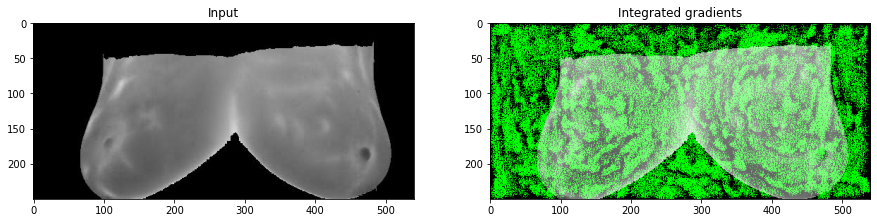

In [24]:
#Wybór obrazu do analizy i wynik jego użycia w modelu
img=x_test[25]
predictions = model.predict(np.expand_dims(img, axis=0))

#Tworzenie integrowanych gradientów
igrads = random_noise(
    np.copy(img), pred=tf.argmax(predictions[0]))

#Wizualizacja wyniku
vis = GradVisualizer()
vis.visualize(
    image=img,
    i_gradients=igrads.numpy(),
    clip_above_percentile=95,
    clip_below_percentile=10,
)